In [1]:
from google.colab import drive
drive.mount('/content/drive')
import os
os.chdir("/content/drive/MyDrive/ABIDE/")

Mounted at /content/drive


In [2]:
!pip install torch==1.11.0 torchvision==0.12.0 torchaudio==0.11.0
!pip install --no-index torch-scatter -f https://pytorch-geometric.com/whl/torch-1.11.0%2Bcu102.html
!pip install --no-index torch-sparse -f https://pytorch-geometric.com/whl/torch-1.11.0%2Bcu102.html
!pip install --no-index torch-cluster -f https://pytorch-geometric.com/whl/torch-1.11.0%2Bcu102.html
!pip install --no-index torch-spline-conv -f https://pytorch-geometric.com/whl/torch-1.11.0%2Bcu102.html
!pip install torch-geometric==2.2.0
import torch
print(torch.__version__)
print(torch.version.cuda)

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 750.6/750.6 MB 2.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.0/21.0 MB 74.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.9/2.9 MB 82.7 MB/s eta 0:00:00
  Attempting uninstall: torch
    Found existing installation: torch 2.0.1+cu118
    Uninstalling torch-2.0.1+cu118:
      Successfully uninstalled torch-2.0.1+cu118
  Attempting uninstall: torchvision
    Found existing installation: torchvision 0.15.2+cu118
    Uninstalling torchvision-0.15.2+cu118:
      Successfully uninstalled torchvision-0.15.2+cu118
  Attempting uninstall: torchaudio
    Found existing installation: torchaudio 2.0.2+cu118
    Uninstalling torchaudio-2.0.2+cu118:
      Successfully uninstalled torchaudio-2.0.2+cu118
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
torchdata 0.6.1 requires torch==2.0.1, 

In [3]:
import sys
sys.path.append('/content/drive/MyDrive/ABIDE/')

In [4]:
from sklearn.model_selection import StratifiedKFold
from sklearn.ensemble import RandomForestClassifier
from sklearn import metrics
from sklearn.metrics import roc_curve, auc
import pandas as pd
from sklearn import svm
import joblib
import openpyxl
from openpyxl import load_workbook
import os
import scipy.io as scio
import argparse
import numpy as np
import time
import torch
import torch.utils.data
import torch.nn as nn
import torch.optim as optim
from torch.utils.data.dataset import Dataset
from torch.autograd import Variable
from torchvision import datasets, transforms
from torchvision.utils import make_grid , save_image
import torchvision.utils as vutils
from os.path import join
from os import listdir
from torch.utils.data.dataloader import DataLoader
from torch.utils.data import DataLoader
from collections import OrderedDict
import nibabel as nib
import matplotlib.pyplot as plt
import cv2 as cv
from os import path
import shutil
import scipy.stats
import scipy.ndimage
import random
import torch.nn.init as init
import torch.nn.functional as F
import sys
import math
from functools import reduce
import operator
from scipy.interpolate import interp1d
from torch.optim import lr_scheduler
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import RidgeClassifier
from sklearn.feature_selection import RFE

def feature_selection_fMRI(matrix, labels, train_ind, fnum):
    """
        matrix       : feature matrix (num_subjects x num_features)
        labels       : ground truth labels (num_subjects x 1)
        train_ind    : indices of the training samples
        fnum         : size of the feature vector after feature selection

    return:
        x_data      : feature matrix of lower dimension (num_subjects x fnum)
    """

    estimator = RidgeClassifier()
    selector = RFE(estimator, n_features_to_select=fnum, step=100, verbose=1)

    featureX = matrix[train_ind, :]
    featureY = labels[train_ind]
    selector = selector.fit(featureX, featureY.ravel())

    return selector
def feature_selection_sMRI(matrix, labels, train_ind, fnum):
    """
        matrix       : feature matrix (num_subjects x num_features)
        labels       : ground truth labels (num_subjects x 1)
        train_ind    : indices of the training samples
        fnum         : size of the feature vector after feature selection

    return:
        x_data      : feature matrix of lower dimension (num_subjects x fnum)
    """

    estimator = RidgeClassifier()
    selector = RFE(estimator, n_features_to_select=fnum, step=100, verbose=1)

    featureX = matrix[train_ind, :]
    featureY = labels[train_ind]
    selector = selector.fit(featureX, featureY.ravel())

    return selector


def get_index(lst=None, item=''):
	return [i for i in range(len(lst)) if lst[i] == item]

def flatten_one(length, img):
	'''
	  In some situations, the dimension on z-axis of images are smaller than
	  the dimension of z-axis of patches, this function will be used to pad
	'''

	one_line = np.zeros((1, int(length)))
	position = 0
	for i in range(img.shape[0]):  # column
		for j in range(i + 1, img.shape[1]):  # row
			one_line[0, position] = img[j, i]
			position = position + 1
	return one_line


def get_ids(num_subjects=None,dir_path=''):
	"""
	return:
		subject_IDs    : list of all subject IDs
	"""
	subject_IDs = np.genfromtxt(os.path.join(dir_path, 'subject_IDs.txt'), dtype=str)

	if num_subjects is not None:
		subject_IDs = subject_IDs[:num_subjects]

	return subject_IDs

def save_model(net,path, name_net):

  # This fucntion is used to save a specific model

    path_net =  path + '/' + name_net + '.pth'
    torch.save(net.cpu().state_dict(), path_net)
    net.cuda()

def load_model(net, path, name_net):

  # This function is used to load a specific model we saved before

    path_net =  path + '/' + name_net + '.pth'
    net.load_state_dict(torch.load(path_net))

    return net

In [23]:
########################################### Load Data ###############################################
#####################################################################################################
#####################################################################################################
fMRI_atlas = 'CC200'  # AAL or CC200
phe = True    # True or False

if phe == False:
  save_phe = '/without_phe/'
else:
  save_phe = '/with_phe/'

# fMRI path
save_path = '/content/drive/MyDrive/ABIDE/save_models/CC200_sMRI/'+ save_phe
root_path_fMRI = '/content/dataset'
if os.path.exists(root_path_fMRI):
  shutil.rmtree(root_path_fMRI)
shutil.copytree('/content/drive/MyDrive/ABIDE/' + fMRI_atlas + '/original/', root_path_fMRI)
label_dir = '/content/drive/MyDrive/ABIDE/phenotypic_image_quality'

# sMRI path
localDir = '/content/sMRI_dataset/'
if os.path.exists(localDir):
  shutil.rmtree(localDir)
os.makedirs(localDir)
!unzip '/content/drive/MyDrive/ABIDE/freesurfer_stats.zip' -d '/content/sMRI_dataset'
localDir = localDir + 'freesurfer_stats/'


k_fold = 5
new_number_features_fMRI = 4000
new_number_features_sMRI = 800
number_samples = 871
useless_samples = ['51334']
if fMRI_atlas == 'AAL':
  image_size = [116, 116]
else:
  image_size = [200, 200]
scaler = True


age_name = 'ages.mat'
gender_name = 'genders.mat'
label_name = 'ABIDE_label_871.mat'
label = scio.loadmat(os.path.join(label_dir, label_name))
label = label['label'][0]
labels = np.zeros(number_samples - len(useless_samples))
site_name = 'sites.mat'
site = scio.loadmat(os.path.join(label_dir, site_name))
all_sites = site['sites']
for i in range(len(all_sites)):
	site = all_sites[i]
	all_sites[i] = site.replace(' ', '')
unique_sites = np.unique(all_sites)
sites = []
unique_sites = list(unique_sites)

age = scio.loadmat(os.path.join(label_dir, age_name))
age = age['ages']
ages = np.zeros((number_samples - len(useless_samples), 1))

gender = scio.loadmat(os.path.join(label_dir, gender_name))
gender = gender['genders']
genders = np.zeros((number_samples - len(useless_samples), 1))

subject_IDs = get_ids(number_samples,dir_path=label_dir)
subject_IDs = subject_IDs.tolist()
length = image_size[0] * (image_size[1]-1) / 2
fMRI_images = np.zeros((number_samples - len(useless_samples), int(length)))

EV_GCN_unique = list(unique_sites)
EV_GCN_site = np.zeros([number_samples - len(useless_samples)], dtype=np.int)
EV_GCN_age = np.zeros([number_samples - len(useless_samples)], dtype=np.float32)
EV_GCN_gender = np.zeros([number_samples - len(useless_samples)], dtype=np.int)

position = 0
print('constructing fMRI features')
for i in range(number_samples):
  subject_name = subject_IDs[i]
  if subject_name in useless_samples:
    subject_index = get_index(lst=subject_IDs, item=subject_name)
    print('The index for sample ' + subject_name + ' is : ', subject_index)
  else:
    image_name = subject_name + '.mat'
    subject_index = get_index(lst=subject_IDs, item=subject_name)
    image = scio.loadmat(os.path.join(root_path_fMRI, image_name))
    img = image['connectivity']

    idx = np.triu_indices_from(img, 1)
    fMRI_images[position, :] = img[idx]
    sites.append(all_sites[subject_index[0]])
    labels[position] = label[subject_index[0]]
    genders[position] = int(gender[subject_index[0]]) + 1
    ages[position] = float(age[subject_index[0]])
    position = position + 1

if scaler == True:
	fMRI_images = StandardScaler().fit_transform(fMRI_images)


for i in range(number_samples - len(useless_samples)):

  EV_GCN_site[i] = EV_GCN_unique.index(sites[i])
  EV_GCN_age[i] = ages[i]
  EV_GCN_gender[i] = genders[i]

phonetic_data = np.zeros([number_samples - len(useless_samples), 3], dtype=np.float32)
phonetic_data[:,0] = EV_GCN_site
phonetic_data[:,1] = EV_GCN_gender
phonetic_data[:,2] = EV_GCN_age

pd_dict = {}
pd_dict['SITE_ID'] = np.copy(phonetic_data[:,0])
pd_dict['SEX'] = np.copy(phonetic_data[:,1])
pd_dict['AGE_AT_SCAN'] = np.copy(phonetic_data[:,2])

流式输出内容被截断，只能显示最后 5000 行内容。
   creating: /content/sMRI_dataset/freesurfer_stats/51095/
  inflating: /content/sMRI_dataset/freesurfer_stats/51095/aseg.stats  
  inflating: /content/sMRI_dataset/freesurfer_stats/51095/brainvol.stats  
  inflating: /content/sMRI_dataset/freesurfer_stats/51095/lh.aparc.a2009s.stats  
  inflating: /content/sMRI_dataset/freesurfer_stats/51095/lh.aparc.DKTatlas.stats  
  inflating: /content/sMRI_dataset/freesurfer_stats/51095/lh.aparc.pial.stats  
  inflating: /content/sMRI_dataset/freesurfer_stats/51095/lh.aparc.stats  
  inflating: /content/sMRI_dataset/freesurfer_stats/51095/lh.BA_exvivo.stats  
  inflating: /content/sMRI_dataset/freesurfer_stats/51095/lh.BA_exvivo.thresh.stats  
  inflating: /content/sMRI_dataset/freesurfer_stats/51095/lh.curv.stats  
  inflating: /content/sMRI_dataset/freesurfer_stats/51095/lh.w-g.pct.stats  
  inflating: /content/sMRI_dataset/freesurfer_stats/51095/rh.aparc.a2009s.stats  
  inflating: /content/sMRI_dataset/freesurfer_sta

<ipython-input-23-a75869c9f04c>:71: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  EV_GCN_site = np.zeros([number_samples - len(useless_samples)], dtype=np.int)
<ipython-input-23-a75869c9f04c>:73: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional

constructing fMRI features
The index for sample 51334 is :  [799]


In [24]:
############################################### Load sMRI ###############################################################
############################################### Load sMRI ###############################################################
############################################### Load sMRI ###############################################################
############################################### Load Desikan_Killiany_features
left = 'lh.aparc.stats'
right = 'rh.aparc.stats'
number_roi = 68
feature_list = ['NumVert', 'SurfArea', 'GrayVol', 'ThickAvg', 'ThickStd', 'MeanCurv', 'GausCurv', 'FoldInd', 'CurvInd']
names = ['StructName', 'NumVert', 'SurfArea', 'GrayVol', 'ThickAvg', 'ThickStd', 'MeanCurv', 'GausCurv', 'FoldInd', 'CurvInd']
skiprows= list(range(0,61))
Desikan_Killiany_features = np.zeros((number_samples - len(useless_samples), number_roi * len(feature_list)))


position = 0
print('constructing Desikan-Killiany Atlas features')
for i in range(number_samples):
  subject_name = subject_IDs[i]
  if subject_name in useless_samples:
    subject_index = get_index(lst=subject_IDs, item=subject_name)
    print('The index for sample ' + subject_name + ' is : ', subject_index)
  else:
    table_left = pd.read_table(localDir + subject_name + '/' + left, sep='\s+', names=names,
						  skiprows=skiprows)
    table_right = pd.read_table(localDir + subject_name + '/' + right, sep='\s+', names=names,
						  skiprows=skiprows)

    for j in range(len(feature_list)):
      feature_name = feature_list[j]
      left_features = table_left[feature_name].values.tolist()
      right_features = table_right[feature_name].values.tolist()
      all_features = left_features + right_features
      if len(all_features) != number_roi:
       print('The sample ' + subject_name + ' has mistake!')
      all_features = np.array(all_features)
      Desikan_Killiany_features[position, j*number_roi : (j+1)*number_roi] = all_features
    position = position + 1

if scaler == True:
	for i in range(len(feature_list)):
		Desikan_Killiany_features[:, i * number_roi: (i+1) * number_roi] = StandardScaler().fit_transform(Desikan_Killiany_features[:, i * number_roi: (i+1) * number_roi])

print('finished')

############################################### Load aseg features
print('constructing aseg features')
number_roi_aseg = 45
aseg = 'aseg.stats'
feature_list_aseg = ['Number of Voxels', 'Volume', 'Intensity normMean', 'Itensity normStdDev', 'Intensity normMin', 'Intensity normMax', 'Intensity normRange']
names_aseg = ['ColHeader Index', 'Segmentation Id ', 'Number of Voxels', 'Volume', 'Structure Name', 'Intensity normMean', 'Itensity normStdDev', 'Intensity normMin', 'Intensity normMax', 'Intensity normRange']
skiprows_aseg= list(range(0,79))
aseg_features = np.zeros((number_samples - len(useless_samples), number_roi_aseg * len(feature_list_aseg)))

position = 0
for i in range(number_samples):
	subject_name = subject_IDs[i]
	if subject_name in useless_samples:
		subject_index = get_index(lst=subject_IDs, item=subject_name)
		print('The index for sample ' + subject_name + ' is : ', subject_index)
	else:
		table_left = pd.read_table(localDir + subject_name + '/' + aseg, sep='\s+', names=names_aseg,
						  skiprows=skiprows_aseg)
		for j in range(len(feature_list_aseg)):
			feature_name = feature_list_aseg[j]
			left_features = table_left[feature_name].values.tolist()
			if len(left_features) != number_roi_aseg:
				print('The sample ' + subject_name + ' has mistake!')
			all_features = np.array(left_features)
			aseg_features[position, j*number_roi_aseg : (j+1)*number_roi_aseg] = all_features
		position = position + 1

if scaler == True:
	for i in range(len(feature_list_aseg)):
		aseg_features[:, i * number_roi_aseg: (i+1) * number_roi_aseg] = StandardScaler().fit_transform(aseg_features[:, i * number_roi_aseg: (i+1) * number_roi_aseg])
print('finished')

############################################### Load wmparc features
number_roi_wmparc = 70
wmparc = 'wmparc.stats'
feature_list_wmparc = ['Number of Voxels', 'Volume', 'Intensity normMean', 'Itensity normStdDev', 'Intensity normMin', 'Intensity normMax', 'Intensity normRange']
names_wmparc = ['ColHeader Index', 'Segmentation Id ', 'Number of Voxels', 'Volume', 'Structure Name', 'Intensity normMean', 'Itensity normStdDev', 'Intensity normMin', 'Intensity normMax', 'Intensity normRange']
skiprows_wmparc= list(range(0,65))
wmparc_features = np.zeros((number_samples - len(useless_samples), number_roi_wmparc * len(feature_list_wmparc)))

print('constructing wmparc features')
position = 0
for i in range(number_samples):
	subject_name = subject_IDs[i]
	if subject_name in useless_samples:
		subject_index = get_index(lst=subject_IDs, item=subject_name)
		print('The index for sample ' + subject_name + ' is : ', subject_index)
	else:
		table_left = pd.read_table(localDir + subject_name + '/' + wmparc, sep='\s+', names = names_wmparc,
						  skiprows=skiprows_wmparc)
		for j in range(len(feature_list_wmparc)):
			feature_name = feature_list_wmparc[j]
			left_features = table_left[feature_name].values.tolist()
			if len(left_features) != number_roi_wmparc:
				print('The sample ' + subject_name + ' has mistake!')
			all_features = np.array(left_features)
			wmparc_features[position, j*number_roi_wmparc : (j+1)*number_roi_wmparc] = all_features
		position = position + 1
if scaler == True:
	for i in range(len(feature_list_wmparc)):
		wmparc_features[:, i * number_roi_wmparc: (i+1) * number_roi_wmparc] = StandardScaler().fit_transform(wmparc_features[:, i * number_roi_wmparc: (i+1) * number_roi_wmparc])
print('finished')

############################################### concatenation
sMRI_features = np.concatenate((Desikan_Killiany_features, aseg_features, wmparc_features),axis = 1)

constructing Desikan-Killiany Atlas features
The index for sample 51334 is :  [799]
finished
constructing aseg features
The index for sample 51334 is :  [799]
finished
constructing wmparc features
The index for sample 51334 is :  [799]
finished


In [25]:
############################################### phenotypic ###############################################################
############################################### phenotypic ###############################################################
############################################### phenotypic ###############################################################
ages_name = 'ages.mat'
ages = scio.loadmat(os.path.join(label_dir, ages_name))
ages = ages['ages']

gender_name = 'genders.mat'
genders = scio.loadmat(os.path.join(label_dir, gender_name))
genders = genders['genders']

FIQ_name = 'FIQS.mat'
FIQS = scio.loadmat(os.path.join(label_dir, FIQ_name))
FIQS = FIQS['FIQS']

NUM_name = 'NUM.mat'
NUM = scio.loadmat(os.path.join(label_dir, NUM_name))
NUMS = NUM['NUM']

PEC_name = 'PEC.mat'
PEC = scio.loadmat(os.path.join(label_dir, PEC_name))
PECS = PEC['PEC']

RAT_name = 'RAT.mat'
RAT = scio.loadmat(os.path.join(label_dir, RAT_name))
RATS = RAT['RAT']

age = np.zeros((number_samples - len(useless_samples), 1))
gender = np.zeros((number_samples - len(useless_samples), 1))
FIQ = np.zeros((number_samples - len(useless_samples), 1))
NUM = np.zeros((number_samples - len(useless_samples), 1))
PEC = np.zeros((number_samples - len(useless_samples), 1))
RAT = np.zeros((number_samples - len(useless_samples), 1))

position = 0
print('constructing phenotypic features')
for i in range(number_samples):
	subject_name = subject_IDs[i]
	if subject_name in useless_samples:
		subject_index = get_index(lst=subject_IDs, item=subject_name)
		print('The index for sample ' + subject_name + ' is : ', subject_index)
	else:
		subject_index = get_index(lst=subject_IDs, item=subject_name)
		age[position] = float(ages[subject_index[0]].replace(' ', ''))
		gender[position] = int(genders[subject_index[0]]) + 1
		FIQ[position] = int(FIQS[subject_index[0]])
		NUM[position] = float(NUMS[subject_index[0]])
		PEC[position] = float(PECS[subject_index[0]])
		RAT[position] = int(RATS[subject_index[0]])
		position = position + 1
FIQ[FIQ == -9999] = 108

if scaler == True:

  age[:,0] = np.squeeze(StandardScaler().fit_transform(np.expand_dims(age[:,0], axis = 1)))
  FIQ[:, 0] = np.squeeze(StandardScaler().fit_transform(np.expand_dims(FIQ[:, 0], axis = 1)))
  NUM[:, 0] = np.squeeze(StandardScaler().fit_transform(np.expand_dims(NUM[:, 0], axis = 1)))
  PEC[:, 0] = np.squeeze(StandardScaler().fit_transform(np.expand_dims(PEC[:, 0], axis = 1)))

# age, gender, FIQ, NUM, PEC, RAT
phe_features = np.concatenate((age, gender, FIQ, NUM, PEC, RAT),axis = 1)
print(phe_features.shape)


constructing phenotypic features
The index for sample 51334 is :  [799]
(870, 6)


In [26]:
dist_train = {}
dist_validation = {}
dist_test = {}
for i in range(k_fold):
	dist_train[str(i + 1)] = []
	dist_validation[str(i + 1)] = []
	dist_test[str(i + 1)] = []

for each_site in unique_sites:
	index_site = get_index(sites, each_site)
	label = np.zeros((len(index_site)))
	for i in range(len(index_site)):
		index = index_site[i]
		label[i] = int(labels[int(index)])
	########################################### StratifiedKFold ####################################################
	sfolder = StratifiedKFold(n_splits=k_fold,random_state=0,shuffle=True)
	group = 0
	for train, validation in sfolder.split(index_site,label):
		for i in train:
			dist_train[str(group + 1)].append(index_site[i])
			name = 0
		for j in validation:
			dist_validation[str(group + 1)].append(index_site[j])
			name = 0
		group = group+1

	group = 0
	for train, validation in sfolder.split(index_site,label):
		if group == 0:
			for j in validation:
				dist_test[str(group + k_fold)].append(index_site[j])
				dist_train[str(group + k_fold)].remove(index_site[j])
		else:
			for j in validation:
				dist_test[str(group)].append(index_site[j])
				dist_train[str(group)].remove(index_site[j])
		group = group+1

In [27]:
import torch.nn as nn
import torch_geometric as tg
from torch.nn import Linear as Lin, Sequential as Seq
############################################### Five models ###############################################################
############################################### Five models ###############################################################
############################################### Five models ###############################################################
# 1. SVM models

############################################### FCN model ###############################################################
# 2. FCN

def single_linear(in_channels, out_channels, dropout):
    return nn.Sequential(
        nn.Linear(in_features=in_channels, out_features=out_channels),
        nn.Dropout(dropout),
        nn.ReLU(inplace=True),
        nn.BatchNorm1d(out_channels)
    )

class FCN(nn.Module):
    def __init__(self, input_c, hid_1, hid_2, out_c, dropout):
        super().__init__()

        self.linear_1 = single_linear(input_c, hid_1, dropout)
        self.linear_2 = nn.Linear(in_features=hid_1, out_features=hid_2)
        self.linear_3 = nn.Linear(in_features=hid_2, out_features=out_c)

        self.dropout = nn.Dropout(dropout)
        self.relu = nn.ReLU(inplace=True)
        self.softmax = nn.LogSoftmax(dim=1)


    def forward(self, x):

        input = torch.flatten(x, start_dim=1, end_dim=-1)
        x = self.relu(self.linear_1(input))
        x = self.relu(self.dropout(self.linear_2(x)))
        x = self.linear_3(x)
        out = self.softmax(x)
        return out
############################################### AUTO+MLP model ###############################################################
# 3. AUTO+MLP

class Stacked_autoencoder(nn.Module):
	def __init__(self, in_c, hid_1, hid_2, hid_3, out, dropout_rate):

		super(Stacked_autoencoder, self).__init__()
		self.linear_1 = nn.Linear(in_features=in_c, out_features=hid_1)
		self.linear_2 = nn.Linear(in_features=hid_1, out_features=hid_2)
		self.linear_3 = nn.Linear(in_features=hid_2, out_features=hid_3)
		self.linear_4 = nn.Linear(in_features=hid_3, out_features=out)
		self.relu = nn.ReLU(inplace=True)
		self.dropout = nn.Dropout(dropout_rate)

	def forward(self, data):

		input_data = torch.flatten(data, start_dim=1, end_dim=-1)
		lin1 = self.relu(self.dropout(self.linear_1(input_data)))
		lin2 = self.relu(self.linear_2(lin1))
		lin3 = self.relu(self.linear_3(lin2))
		lin4 = self.relu(self.linear_4(lin3))

		return lin4

class MLP(nn.Module):
	def __init__(self, in_c, hid_1, hid_2, out, dropout_rate):

		super(MLP, self).__init__()
		self.linear_1 = nn.Linear(in_features=in_c, out_features=hid_1)
		self.linear_2 = nn.Linear(in_features=hid_1, out_features=hid_2)
		self.linear_3 = nn.Linear(in_features=hid_2, out_features=out)
		self.relu = nn.ReLU(inplace=True)
		self.dropout = nn.Dropout(dropout_rate)

	def forward(self, data):

		lin1 = self.relu(self.linear_1(data))
		lin2 = self.dropout(self.relu(self.linear_2(lin1)))
		lin3 = self.linear_3(lin2)

		return lin3


class Auto_encoder_MLP(nn.Module):
	def __init__(self, in_c, auto_1, auto_2, auto_3, MLP_1, MLP_2, MLP_out, dropout_rate):

		super(Auto_encoder_MLP, self).__init__()
		self.auto_encoder = Stacked_autoencoder(in_c, auto_1, auto_2, auto_3, in_c, dropout_rate)
		self.MLP = MLP(in_c, MLP_1, MLP_2, MLP_out, dropout_rate)
		self.softmax = nn.LogSoftmax(dim=1)

	def forward(self, data):

		auto_output = self.auto_encoder(data)
		MLP_out = self.MLP(auto_output)
		out = self.softmax(MLP_out)

		return out, auto_output
############################################### GCN model ###############################################################
# 4. GCN

class GCN(nn.Module):
    def __init__(self, in_c, hid_c, out_c, K, dropout_rate, normalize=True):
        """
        :param in_c: int, number of input channels.
        :param hid_c: int, number of hidden channels.
        :param out_c: int, number of output channels.
        :param K:
        """
        super(GCN, self).__init__()
        self.normalize = normalize

        self.conv1 = tg.nn.ChebConv(in_c, hid_c, K, normalization='sym', bias=True)
        self.conv2 = tg.nn.ChebConv(hid_c, hid_c, K, normalization='sym', bias=True)
        self.conv3 = tg.nn.ChebConv(hid_c, out_c, K, normalization='sym', bias=True)
        self.relu = nn.ReLU(inplace=True)
        self.dropout = nn.Dropout(dropout_rate)
        self.softmax = nn.LogSoftmax(dim=1)


    def forward(self, data, edge_index, edgenet_input):

        edge_weight = torch.squeeze(edgenet_input)
        # data = self.dropout(data)
        h = self.relu(self.dropout(self.conv1(data, edge_index, edge_weight)))
        h = self.relu(self.dropout(self.conv2(h, edge_index, edge_weight)))
        h = self.conv3(h, edge_index, edge_weight)

        return self.softmax(h)
############################################### EV-GCN ###############################################################
# 5. EV_GCN

class PAE(torch.nn.Module):
    def __init__(self, input_dim, dropout=0.2):
        super(PAE, self).__init__()
        hidden=128
        self.parser =nn.Sequential(
                nn.Linear(input_dim, hidden, bias=True),
                nn.ReLU(inplace=True),
                nn.BatchNorm1d(hidden),
                nn.Dropout(dropout),
                nn.Linear(hidden, hidden, bias=True),
                )
        self.cos = nn.CosineSimilarity(dim=1, eps=1e-8)
        self.input_dim = input_dim
        self.model_init()
        self.relu = nn.ReLU(inplace=True)
        self.elu = nn.ReLU()

    def forward(self, x):
        x1 = x[:,0:self.input_dim]
        x2 = x[:,self.input_dim:]
        h1 = self.parser(x1)
        h2 = self.parser(x2)
        p = (self.cos(h1,h2) + 1)*0.5
        return p

    def model_init(self):
        for m in self.modules():
            if isinstance(m, Lin):
                torch.nn.init.kaiming_normal_(m.weight)
                m.weight.requires_grad = True
                if m.bias is not None:
                    m.bias.data.zero_()
                    m.bias.requires_grad = True


class EV_GCN(torch.nn.Module):
    def __init__(self, input_dim, num_classes, dropout, edgenet_input_dim, edge_dropout, hgc, lg):
        super(EV_GCN, self).__init__()
        K=2
        hidden = [hgc for i in range(lg)]
        self.dropout = dropout
        self.edge_dropout = edge_dropout
        bias = False
        self.relu = torch.nn.ReLU(inplace=True)
        self.lg = lg
        self.gconv = nn.ModuleList()
        for i in range(lg):
            in_channels = input_dim if i==0  else hidden[i-1]
            self.gconv.append(tg.nn.ChebConv(in_channels, hidden[i], K, normalization='sym', bias=bias))
        cls_input_dim = sum(hidden)

        self.cls = nn.Sequential(
                torch.nn.Linear(cls_input_dim, 256),
                torch.nn.ReLU(inplace=True),
                nn.BatchNorm1d(256),
                torch.nn.Linear(256, num_classes))

        self.edge_net = PAE(input_dim=edgenet_input_dim//2, dropout=dropout)
        self.model_init()
        self.softmax = nn.LogSoftmax(dim=1)

    def model_init(self):
        for m in self.modules():
            if isinstance(m, Lin):
                torch.nn.init.kaiming_normal_(m.weight)
                m.weight.requires_grad = True
                if m.bias is not None:
                    m.bias.data.zero_()
                    m.bias.requires_grad = True

    def forward(self, features, edge_index, edgenet_input, enforce_edropout=False):
        if self.edge_dropout>0:
            if enforce_edropout or self.training:
                one_mask = torch.ones([edgenet_input.shape[0],1]).cuda()
                self.drop_mask = F.dropout(one_mask, self.edge_dropout, True)
                self.bool_mask = torch.squeeze(self.drop_mask.type(torch.bool))
                edge_index = edge_index[:, self.bool_mask]
                edgenet_input = edgenet_input[self.bool_mask]


        edge_weight = torch.squeeze(self.edge_net(edgenet_input))
        features = F.dropout(features, self.dropout, self.training)
        h = self.relu(self.gconv[0](features, edge_index, edge_weight))
        h0 = h
        for i in range(1, self.lg):
            h = F.dropout(h, self.dropout, self.training)
            h= self.relu(self.gconv[i](h, edge_index, edge_weight))
            jk = torch.cat((h0, h), axis=1)
            h0 = jk
        logit = self.cls(jk)


        return self.softmax(logit), edge_weight

In [28]:
from scipy.spatial import distance

def get_subject_score(subject_list,l, path, all_subject_list):

    name = l + '.mat'
    file = scio.loadmat(os.path.join(path, name))
    file = file[l]
    label_dict = {}
    for i in subject_list:
        sample_index = get_index(lst=all_subject_list, item=i)
        value = file[sample_index[0]]
        if l == 'genders':
            label_dict[i] = int(value)
        elif l == 'ages':
            label_dict[i] = float(value)
        elif l == 'FIQS':
            label_dict[i] = float(value)
        elif l == 'NUM':
            label_dict[i] = int(value)
        elif l == 'PEC':
            label_dict[i] = float(value)
        elif l == 'RAT':
            label_dict[i] = int(value)
        elif l == 'sites':
            label_dict[i] = value.replace(' ', '')
        else:
            label_dict[i] = value
    return label_dict

def create_graph_from_scores(scores, subject_list, path, all_subject_list):
    """
        scores       : list of phenotypic information to be used to construct the affinity graph
        subject_list : list of subject IDs
    return:
        graph        : adjacency matrix of the population graph (num_subjects x num_subjects)
    """

    num_nodes = len(subject_list)
    graph = np.zeros((num_nodes, num_nodes))

    for l in scores:
        label_dict = get_subject_score(subject_list, l, path, all_subject_list)

        # quantitative phenotypic scores
        if l in ['ages']:
            for k in range(num_nodes):
                for j in range(k + 1, num_nodes):
                    try:
                        val = abs(float(label_dict[subject_list[k]]) - float(label_dict[subject_list[j]]))
                        if val < 2:
                            graph[k, j] += 1
                            graph[j, k] += 1
                    except ValueError:  # missing label
                        pass
        elif l in ['FIQ']:
            for k in range(num_nodes):
                for j in range(k + 1, num_nodes):
                    try:
                        val = abs(float(label_dict[subject_list[k]]) - float(label_dict[subject_list[j]]))
                        if val < 10:
                            graph[k, j] += 1
                            graph[j, k] += 1
                    except ValueError:  # missing label
                        pass

        else:
            for k in range(num_nodes):
                for j in range(k + 1, num_nodes):
                    if label_dict[subject_list[k]] == label_dict[subject_list[j]]:
                        graph[k, j] += 1
                        graph[j, k] += 1

    return graph


def EV_GCN_create_affinity_graph_from_scores(scores, pd_dict):
    num_nodes = len(pd_dict[scores[0]])
    graph = np.zeros((num_nodes, num_nodes))

    for l in scores:
        label_dict = pd_dict[l]

        if l in ['AGE_AT_SCAN', 'FIQ']:
            for k in range(num_nodes):
                for j in range(k + 1, num_nodes):
                    try:
                        val = abs(float(label_dict[k]) - float(label_dict[j]))
                        if val < 2:
                            graph[k, j] += 1
                            graph[j, k] += 1
                    except ValueError:  # missing label
                        pass

        else:
            for k in range(num_nodes):
                for j in range(k + 1, num_nodes):
                    if label_dict[k] == label_dict[j]:
                        graph[k, j] += 1
                        graph[j, k] += 1

    return graph

def EV_GCN_get_static_affinity_adj(features, pd_dict):
    pd_affinity = EV_GCN_create_affinity_graph_from_scores(['SEX', 'SITE_ID'], pd_dict)
    distv = distance.pdist(features, metric='correlation')
    dist = distance.squareform(distv)
    sigma = np.mean(dist)
    feature_sim = np.exp(- dist ** 2 / (2 * sigma ** 2))
    adj = pd_affinity * feature_sim

    return adj



all_subject_IDs = get_ids(number_samples,dir_path=label_dir)
all_subject_IDs = all_subject_IDs.tolist()
for i in useless_samples:
    subject_IDs.remove(i)

graph = create_graph_from_scores(['sites'], subject_IDs, label_dir,all_subject_IDs)



ALL_labels = np.zeros((number_samples - len(useless_samples), 2))
for i in range(len(labels)):
    if labels[i] == 1:
        ALL_labels[i,0] = 1
    else:
        ALL_labels[i,1] = 1

selectors_fMRI= {}
selectors_sMRI= {}
selectors_combine= {}
fold_data_SVM = {}
FCN_data = {}
GCN_data = {}
EV_GCN_data = {}
for i in range(0, k_fold):

  ################################################# feature selection #########################################################
  selectors_fMRI[str(i+1)] = feature_selection_fMRI(fMRI_images, labels, dist_train[str(i+1)], new_number_features_fMRI)
  selectors_sMRI[str(i+1)] = feature_selection_sMRI(sMRI_features, labels, dist_train[str(i+1)], new_number_features_sMRI)

  new_fMRI_data = selectors_fMRI[str(i+1)].transform(fMRI_images)
  new_sMRI_data = selectors_sMRI[str(i+1)].transform(sMRI_features)
  ################################################# combine ##########################################
  if phe == True:
    fold_data = np.concatenate((new_fMRI_data,new_sMRI_data,phe_features), axis = 1)
    print(fold_data.shape)
  else:
    fold_data = np.concatenate((new_fMRI_data,new_sMRI_data), axis = 1)
    print(fold_data.shape)

  fold_data_SVM[str(i+1)] = fold_data

  FCN_data[str(i+1)] = []
  FCN_data[str(i+1)].append(fold_data)
  FCN_data[str(i+1)].append(ALL_labels)
######################################################### GCN ###########################################################
  n = fold_data.shape[0]
  num_edge = n * n
  edge_index = np.zeros([2, num_edge], dtype=np.int64)
  edgenet_input = np.zeros([num_edge, 1], dtype=np.float32)
  aff_score = np.zeros(num_edge, dtype=np.float32)
  flatten_ind = 0

  for x in range(n):
    for y in range(n):
      edge_index[:, flatten_ind] = [x, y]
      edgenet_input[flatten_ind] = graph[x,y]
      aff_score[flatten_ind] = graph[x,y]
      flatten_ind += 1


  keep_ind = np.where(aff_score > 0.99)[0]
  edge_index = edge_index[:, keep_ind]
  edgenet_input = edgenet_input[keep_ind]
  GCN_data[str(i+1)] = []
  GCN_data[str(i+1)].append(fold_data)
  GCN_data[str(i+1)].append(ALL_labels)
  GCN_data[str(i+1)].append(edge_index)
  GCN_data[str(i+1)].append(edgenet_input)

######################################################### EV_GCN ###########################################################
  n = fold_data.shape[0]
  num_edge = n * n
  edge_index = np.zeros([2, num_edge], dtype=np.int64)
  edgenet_input = np.zeros([num_edge, 2*phonetic_data.shape[1]], dtype=np.float32)
  aff_score = np.zeros(num_edge, dtype=np.float32)
  aff_adj = EV_GCN_get_static_affinity_adj(fold_data, pd_dict)

  flatten_ind = 0
  for x in range(n):
    for y in range(n):
      edge_index[:, flatten_ind] = [x, y]
      edgenet_input[flatten_ind] = np.concatenate((phonetic_data[x], phonetic_data[y]))
      aff_score[flatten_ind] = aff_adj[x][y]
      flatten_ind += 1


  keep_ind = np.where(aff_score > 1.1)[0]
  edge_index = edge_index[:, keep_ind]
  edgenet_input = edgenet_input[keep_ind]
  edgenet_input = (edgenet_input- edgenet_input.mean(axis=0)) / edgenet_input.std(axis=0)

  EV_GCN_data[str(i+1)] = []
  EV_GCN_data[str(i+1)].append(fold_data)
  print(fold_data)
  EV_GCN_data[str(i+1)].append(ALL_labels)
  EV_GCN_data[str(i+1)].append(edge_index)
  EV_GCN_data[str(i+1)].append(edgenet_input)


  # ################################################# feature selection #########################################################
  # selector_fMRI = selectors_fMRI[str(i+1)]
  # selector_sMRI = selectors_sMRI[str(i+1)]

  # new_fMRI_data = selector_fMRI.transform(fMRI_images)
  # new_sMRI_data = selector_sMRI.transform(sMRI_features)
  # ################################################# combine ##########################################
  # sMRI_fMRI_combine = np.concatenate((new_sMRI_data, new_fMRI_data), axis = 1)
  # selector_combine = selectors_combine[str(i+1)]
  # sMRI_fMRI_combine = selector_combine.transform(sMRI_fMRI_combine)

Fitting estimator with 19900 features.
Fitting estimator with 19800 features.
Fitting estimator with 19700 features.
Fitting estimator with 19600 features.
Fitting estimator with 19500 features.
Fitting estimator with 19400 features.
Fitting estimator with 19300 features.
Fitting estimator with 19200 features.
Fitting estimator with 19100 features.
Fitting estimator with 19000 features.
Fitting estimator with 18900 features.
Fitting estimator with 18800 features.
Fitting estimator with 18700 features.
Fitting estimator with 18600 features.
Fitting estimator with 18500 features.
Fitting estimator with 18400 features.
Fitting estimator with 18300 features.
Fitting estimator with 18200 features.
Fitting estimator with 18100 features.
Fitting estimator with 18000 features.
Fitting estimator with 17900 features.
Fitting estimator with 17800 features.
Fitting estimator with 17700 features.
Fitting estimator with 17600 features.
Fitting estimator with 17500 features.
Fitting estimator with 17

In [29]:
############################################### SVM ###############################################################
############################################### SVM ###############################################################
############################################### SVM ###############################################################
average_test = 0
for i in range(0, k_fold):

  ################################################# feature selection #########################################################
  # selector_fMRI = selectors_fMRI[str(i+1)]
  # selector_sMRI = selectors_sMRI[str(i+1)]

  # new_fMRI_data = selector_fMRI.transform(fMRI_images)
  # new_sMRI_data = selector_sMRI.transform(sMRI_features)
  # ################################################# combine ##########################################
  # sMRI_fMRI_combine = np.concatenate((new_sMRI_data, new_fMRI_data), axis = 1)
  # selector_combine = selectors_combine[str(i+1)]
  sMRI_fMRI_combine = fold_data_SVM[str(i+1)]
  print(sMRI_fMRI_combine)
  ###############################################################################################################
  model_name = save_path + 'SVM_'+str(i+1) + '.m'
  model = joblib.load(model_name)

  test_images = np.zeros((len(dist_test[str(i+1)]), sMRI_fMRI_combine.shape[1]))
  test_labels = np.zeros((len(dist_test[str(i + 1)]), 1))

  test_images[:,:] = sMRI_fMRI_combine[dist_test[str(i+1)],:]
  test_labels[:, 0] = labels[dist_test[str(i + 1)]]
  # test_images = selector.transform(test_images)

  print('Model_'+ str(i+1))
  test_results = model.predict(test_images)
  test_results_prob = model.predict_proba(test_images)

  test_accuracy = metrics.accuracy_score(test_labels, test_results)
  if i == 0:
    test_labels_concat = test_labels
    SVM_results_concat = test_results
    SVM_results_prob_concat = test_results_prob
  else:
    test_labels_concat = np.concatenate((test_labels_concat, test_labels),axis = 0)
    SVM_results_concat = np.concatenate((SVM_results_concat, test_results),axis = 0)
    SVM_results_prob_concat = np.concatenate((SVM_results_prob_concat, test_results_prob),axis = 0)



test_labels_concat = np.squeeze(test_labels_concat)
test_accuracy = metrics.accuracy_score(test_labels_concat, SVM_results_concat)
print(test_accuracy)
print(test_labels_concat)
print(SVM_results_concat)
print(SVM_results_prob_concat)


[[ 1.88061923  0.63599984 -2.11456036 ...  3.49813732  3.75373858
   1.        ]
 [ 0.66500812 -0.205227   -0.02036448 ...  0.246303    0.26516346
   1.        ]
 [ 0.10988633  0.03347263 -0.46156094 ...  0.03155922  0.03478586
   1.        ]
 ...
 [-1.36387375 -0.33001366 -0.88808432 ...  0.95188969  1.02211844
   1.        ]
 [-1.53608071 -0.2103792  -0.74824874 ... -0.64334978 -0.68925803
   1.        ]
 [-0.10758455  1.34416595  0.84995217 ...  0.70646823  1.71624316
   1.        ]]
Model_1
[[ 0.63599984 -1.27326899  0.99574913 ...  3.49813732  3.75373858
   1.        ]
 [-0.205227   -0.69566366 -0.0945248  ...  0.246303    0.26516346
   1.        ]
 [ 0.03347263  1.49062301  0.72253173 ...  0.03155922  0.03478586
   1.        ]
 ...
 [-0.33001366 -0.55137352  0.28816686 ...  0.95188969  1.02211844
   1.        ]
 [-0.2103792   0.69156166 -1.91540226 ... -0.64334978 -0.68925803
   1.        ]
 [ 1.34416595  1.59411073 -0.57512426 ...  0.70646823  1.71624316
   1.        ]]
Model_2


In [30]:
########################################### FCN ################################################
########################################### FCN ################################################
########################################### FCN ################################################
parser = argparse.ArgumentParser()
parser.add_argument('--ngpu', type=int, default=1)
parser.add_argument('--seed', type=int, default=1)
parser.add_argument('--no-cuda', action='store_true')
parser.add_argument('--input_c', type=int, default=fold_data.shape[1])
parser.add_argument('--hid_1', type=int, default=500)
parser.add_argument('--hid_2', type=int, default=30)
parser.add_argument('--out_c', type=int, default=2)
parser.add_argument('--dropout_rate', type=int, default=0.5)

args, unknown = parser.parse_known_args()
args.cuda = not args.no_cuda and torch.cuda.is_available()
torch.manual_seed(args.seed)
if args.cuda:
    torch.cuda.manual_seed(args.seed)

model_1 = FCN(input_c=args.input_c, hid_1=args.hid_1, hid_2=args.hid_2, out_c=args.out_c, dropout=args.dropout_rate)
model_2 = FCN(input_c=args.input_c, hid_1=args.hid_1, hid_2=args.hid_2, out_c=args.out_c, dropout=args.dropout_rate)
model_3 = FCN(input_c=args.input_c, hid_1=args.hid_1, hid_2=args.hid_2, out_c=args.out_c, dropout=args.dropout_rate)
model_4 = FCN(input_c=args.input_c, hid_1=args.hid_1, hid_2=args.hid_2, out_c=args.out_c, dropout=args.dropout_rate)
model_5 = FCN(input_c=args.input_c, hid_1=args.hid_1, hid_2=args.hid_2, out_c=args.out_c, dropout=args.dropout_rate)

gpu_ids = range(args.ngpu)
model_1 = nn.parallel.DataParallel(model_1, device_ids=gpu_ids)
model_2 = nn.parallel.DataParallel(model_2, device_ids=gpu_ids)
model_3 = nn.parallel.DataParallel(model_3, device_ids=gpu_ids)
model_4 = nn.parallel.DataParallel(model_4, device_ids=gpu_ids)
model_5 = nn.parallel.DataParallel(model_5, device_ids=gpu_ids)

print('  + Number of params: {}'.format(
    sum([p.data.nelement() for p in model_1.parameters()])))
if args.cuda:
    model_1 = model_1.cuda()
    model_2 = model_2.cuda()
    model_3 = model_3.cuda()
    model_4 = model_4.cuda()
    model_5 = model_5.cuda()


model_1 = load_model(model_1, save_path, 'FCN_' + str(1))
model_2 = load_model(model_2, save_path, 'FCN_' + str(2))
model_3 = load_model(model_3, save_path, 'FCN_' + str(3))
model_4 = load_model(model_4, save_path, 'FCN_' + str(4))
model_5 = load_model(model_5, save_path, 'FCN_' + str(5))

  + Number of params: 2419592


In [31]:
for fold in range(1, k_fold+1):
    if fold == 1:
        model = model_1.eval()
    elif fold == 2:
        model = model_2.eval()
    elif fold == 3:
        model = model_3.eval()
    elif fold == 4:
        model = model_4.eval()
    elif fold == 5:
        model = model_5.eval()

    fold_test_index = dist_test[str(fold)]

    model.eval()

    data = torch.from_numpy(FCN_data[str(fold)][0])
    data = Variable(data, requires_grad=False)
    data = data.float()

    target = torch.from_numpy(FCN_data[str(fold)][1])
    target = target.float().long()

    if args.cuda:
        data, target = data.cuda(), target.cuda()

    data_test = data[fold_test_index,:]
    target = target[fold_test_index, :]
    out = model(data_test)

    out_prob = torch.exp(out)
    out = torch.max(out, 1)[1]
    target = torch.max(target, 1)[1]
    target = target.cpu().numpy()
    out = out.cpu().numpy()
    out_prob = out_prob.cpu().detach().numpy()
    if fold == 1:
      FCN_labels_concat = target
      FCN_results_concat = out
      FCN_results_prob_concat = out_prob
    else:
      FCN_labels_concat = np.concatenate((FCN_labels_concat, target),axis = 0)
      FCN_results_concat = np.concatenate((FCN_results_concat, out),axis = 0)
      FCN_results_prob_concat = np.concatenate((FCN_results_prob_concat, out_prob),axis = 0)

FCN_labels_concat = 1 - FCN_labels_concat
FCN_results_concat = 1 - FCN_results_concat
FCN_results_prob_concat_change = np.zeros_like(FCN_results_prob_concat)
FCN_results_prob_concat_change[:,0] = FCN_results_prob_concat[:,1]
FCN_results_prob_concat_change[:,1] = FCN_results_prob_concat[:,0]

test_accuracy = metrics.accuracy_score(FCN_labels_concat, FCN_results_concat)
print(test_accuracy)
print(FCN_labels_concat)
print(FCN_results_concat)
print(FCN_results_prob_concat_change)


0.6505747126436782
[1 0 0 1 0 0 0 0 1 1 1 0 0 1 1 1 0 0 0 0 0 1 1 1 1 1 1 1 0 0 0 0 0 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 0 0 0
 0 0 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 1 1 1 1 0 0 0 0 1 1 1 0 0 1 1 1 1 0 0
 0 0 0 1 1 1 1 1 1 1 1 0 0 0 0 0 1 1 0 0 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0
 0 1 1 1 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 0 0 0 0 1 1 1 1 1 0 0 1 0 0 0 1
 1 0 0 1 0 0 0 1 1 1 0 0 0 1 1 1 1 1 1 0 0 0 1 0 0 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 0 0 0 0 0 0 1 1 1 1 1 1 1
 0 0 0 0 1 0 0 0 0 1 1 1 1 0 0 0 1 1 0 0 0 1 1 1 1 0 0 0 0 0 1 1 1 1 1 1 1
 0 0 0 0 0 0 1 1 0 0 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 0 0 0 0 0
 0 0 1 1 1 1 1 1 1 1 0 0 0 0 1 1 1 1 1 0 0 1 0 0 0 1 0 0 1 0 0 1 0 1 0 0 0
 1 1 1 1 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 1 1 0 0 0 0 0 0 1 1 1 1 1 1 0 0 0 0 0 1 0 0 0 1 1 1 0 0 0
 0 1 1 0 0 0 1 1 1 1 0 0 0 0 0 1 1 1 1 1 1 1 0 0 0 0 0 0 1 1 0 0 1 1 1 1 1
 1 1 0

In [32]:
########################################### AUTO ################################################
########################################### AUTO ################################################
########################################### AUTO ################################################
torch.cuda.empty_cache()
parser = argparse.ArgumentParser()
parser.add_argument('--ngpu', type=int, default=1)
parser.add_argument('--no-cuda', action='store_true')
parser.add_argument('--seed', type=int, default=1)
parser.add_argument('--auto_in', type=int, default=fold_data.shape[1])
parser.add_argument('--auto_hid_1', type=int, default=500)
parser.add_argument('--auto_hid_2', type=int, default=150)
parser.add_argument('--auto_hid_3', type=int, default=500)
parser.add_argument('--MLP_1', type=int, default=300)
parser.add_argument('--MLP_2', type=int, default=16)
parser.add_argument('--MLP_out', type=int, default=2)
parser.add_argument('--dropout_rate', type=int, default=0.5)

args, unknown = parser.parse_known_args()
args.cuda = not args.no_cuda and torch.cuda.is_available()
torch.manual_seed(args.seed)
if args.cuda:
    torch.cuda.manual_seed(args.seed)

print("build AUTO pytorch")
model_1 = Auto_encoder_MLP(in_c=args.auto_in, auto_1=args.auto_hid_1, auto_2=args.auto_hid_2, auto_3=args.auto_hid_3, MLP_1=args.MLP_1, MLP_2=args.MLP_2, MLP_out=args.MLP_out, dropout_rate=args.dropout_rate)
model_2 = Auto_encoder_MLP(in_c=args.auto_in, auto_1=args.auto_hid_1, auto_2=args.auto_hid_2, auto_3=args.auto_hid_3, MLP_1=args.MLP_1, MLP_2=args.MLP_2, MLP_out=args.MLP_out, dropout_rate=args.dropout_rate)
model_3 = Auto_encoder_MLP(in_c=args.auto_in, auto_1=args.auto_hid_1, auto_2=args.auto_hid_2, auto_3=args.auto_hid_3, MLP_1=args.MLP_1, MLP_2=args.MLP_2, MLP_out=args.MLP_out, dropout_rate=args.dropout_rate)
model_4 = Auto_encoder_MLP(in_c=args.auto_in, auto_1=args.auto_hid_1, auto_2=args.auto_hid_2, auto_3=args.auto_hid_3, MLP_1=args.MLP_1, MLP_2=args.MLP_2, MLP_out=args.MLP_out, dropout_rate=args.dropout_rate)
model_5 = Auto_encoder_MLP(in_c=args.auto_in, auto_1=args.auto_hid_1, auto_2=args.auto_hid_2, auto_3=args.auto_hid_3, MLP_1=args.MLP_1, MLP_2=args.MLP_2, MLP_out=args.MLP_out, dropout_rate=args.dropout_rate)

gpu_ids = range(args.ngpu)
model_1 = nn.parallel.DataParallel(model_1, device_ids=gpu_ids)
model_2 = nn.parallel.DataParallel(model_2, device_ids=gpu_ids)
model_3 = nn.parallel.DataParallel(model_3, device_ids=gpu_ids)
model_4 = nn.parallel.DataParallel(model_4, device_ids=gpu_ids)
model_5 = nn.parallel.DataParallel(model_5, device_ids=gpu_ids)

print('  + Number of params: {}'.format(
    sum([p.data.nelement() for p in model_1.parameters()])))
if args.cuda:
    model_1 = model_1.cuda()
    model_2 = model_2.cuda()
    model_3 = model_3.cuda()
    model_4 = model_4.cuda()
    model_5 = model_5.cuda()

model_1 = load_model(model_1, save_path, 'AUTO_' + str(1))
model_2 = load_model(model_2, save_path, 'AUTO_' + str(2))
model_3 = load_model(model_3, save_path, 'AUTO_' + str(3))
model_4 = load_model(model_4, save_path, 'AUTO_' + str(4))
model_5 = load_model(model_5, save_path, 'AUTO_' + str(5))


build AUTO pytorch
  + Number of params: 6408906


In [33]:
for fold in range(1, k_fold+1):
    if fold == 1:
        model = model_1.eval()
    elif fold == 2:
        model = model_2.eval()
    elif fold == 3:
        model = model_3.eval()
    elif fold == 4:
        model = model_4.eval()
    elif fold == 5:
        model = model_5.eval()

    fold_test_index = dist_test[str(fold)]

    model.eval()

    data = torch.from_numpy(FCN_data[str(fold)][0])
    data = Variable(data, requires_grad=False)
    data = data.float()

    target = torch.from_numpy(FCN_data[str(fold)][1])
    target = target.float().long()

    if args.cuda:
        data, target = data.cuda(), target.cuda()

    data_test = data[fold_test_index,:]
    target = target[fold_test_index, :]
    out,out_auto = model(data_test)

    out_prob = torch.exp(out)
    out = torch.max(out, 1)[1]
    target = torch.max(target, 1)[1]
    target = target.cpu().numpy()
    out = out.cpu().numpy()
    out_prob = out_prob.cpu().detach().numpy()

    if fold == 1:
      AUTO_labels_concat = target
      AUTO_results_concat = out
      AUTO_results_prob_concat = out_prob
    else:
      AUTO_labels_concat = np.concatenate((AUTO_labels_concat, target),axis = 0)
      AUTO_results_concat = np.concatenate((AUTO_results_concat, out),axis = 0)
      AUTO_results_prob_concat = np.concatenate((AUTO_results_prob_concat, out_prob),axis = 0)

AUTO_labels_concat = 1 - AUTO_labels_concat
AUTO_results_concat = 1 - AUTO_results_concat
AUTO_results_prob_concat_change = np.zeros_like(AUTO_results_prob_concat)
AUTO_results_prob_concat_change[:,0] = AUTO_results_prob_concat[:,1]
AUTO_results_prob_concat_change[:,1] = AUTO_results_prob_concat[:,0]

test_accuracy = metrics.accuracy_score(AUTO_labels_concat, AUTO_results_concat)
print(test_accuracy)
print(AUTO_labels_concat)
print(AUTO_results_concat)
print(AUTO_results_prob_concat_change)


0.6597701149425287
[1 0 0 1 0 0 0 0 1 1 1 0 0 1 1 1 0 0 0 0 0 1 1 1 1 1 1 1 0 0 0 0 0 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 0 0 0
 0 0 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 1 1 1 1 0 0 0 0 1 1 1 0 0 1 1 1 1 0 0
 0 0 0 1 1 1 1 1 1 1 1 0 0 0 0 0 1 1 0 0 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0
 0 1 1 1 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 0 0 0 0 1 1 1 1 1 0 0 1 0 0 0 1
 1 0 0 1 0 0 0 1 1 1 0 0 0 1 1 1 1 1 1 0 0 0 1 0 0 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 0 0 0 0 0 0 1 1 1 1 1 1 1
 0 0 0 0 1 0 0 0 0 1 1 1 1 0 0 0 1 1 0 0 0 1 1 1 1 0 0 0 0 0 1 1 1 1 1 1 1
 0 0 0 0 0 0 1 1 0 0 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 0 0 0 0 0
 0 0 1 1 1 1 1 1 1 1 0 0 0 0 1 1 1 1 1 0 0 1 0 0 0 1 0 0 1 0 0 1 0 1 0 0 0
 1 1 1 1 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 1 1 0 0 0 0 0 0 1 1 1 1 1 1 0 0 0 0 0 1 0 0 0 1 1 1 0 0 0
 0 1 1 0 0 0 1 1 1 1 0 0 0 0 0 1 1 1 1 1 1 1 0 0 0 0 0 0 1 1 0 0 1 1 1 1 1
 1 1 0

In [34]:
########################################### GCN ################################################
########################################### GCN ################################################
########################################### GCN ################################################
torch.cuda.empty_cache()
parser = argparse.ArgumentParser()
parser.add_argument('--ngpu', type=int, default=1)
parser.add_argument('--no-cuda', action='store_true')
parser.add_argument('--seed', type=int, default=1)
parser.add_argument('--cheby_order_K', type=int, default=2)
parser.add_argument('--input_dimension', type=int, default=fold_data.shape[1])
parser.add_argument('--hidden_dimension', type=int, default=32)
parser.add_argument('--output_dimension', type=int, default=2)
parser.add_argument('--dropout_rate', type=int, default=0.3)
#
args, unknown = parser.parse_known_args()
args.cuda = not args.no_cuda and torch.cuda.is_available()
torch.manual_seed(args.seed)
if args.cuda:
    torch.cuda.manual_seed(args.seed)

print("build GCN pytorch")
model_1 = GCN(in_c=args.input_dimension, hid_c=args.hidden_dimension, out_c=args.output_dimension, K=args.cheby_order_K, dropout_rate=args.dropout_rate)
model_2 = GCN(in_c=args.input_dimension, hid_c=args.hidden_dimension, out_c=args.output_dimension, K=args.cheby_order_K, dropout_rate=args.dropout_rate)
model_3 = GCN(in_c=args.input_dimension, hid_c=args.hidden_dimension, out_c=args.output_dimension, K=args.cheby_order_K, dropout_rate=args.dropout_rate)
model_4 = GCN(in_c=args.input_dimension, hid_c=args.hidden_dimension, out_c=args.output_dimension, K=args.cheby_order_K, dropout_rate=args.dropout_rate)
model_5 = GCN(in_c=args.input_dimension, hid_c=args.hidden_dimension, out_c=args.output_dimension, K=args.cheby_order_K, dropout_rate=args.dropout_rate)

gpu_ids = range(args.ngpu)
model_1 = nn.parallel.DataParallel(model_1, device_ids=gpu_ids)
model_2 = nn.parallel.DataParallel(model_2, device_ids=gpu_ids)
model_3 = nn.parallel.DataParallel(model_3, device_ids=gpu_ids)
model_4 = nn.parallel.DataParallel(model_4, device_ids=gpu_ids)
model_5 = nn.parallel.DataParallel(model_5, device_ids=gpu_ids)

print('  + Number of params: {}'.format(
    sum([p.data.nelement() for p in model_1.parameters()])))
if args.cuda:
    model_1 = model_1.cuda()
    model_2 = model_2.cuda()
    model_3 = model_3.cuda()
    model_4 = model_4.cuda()
    model_5 = model_5.cuda()

model_1 = load_model(model_1, save_path, 'GCN_' + str(1))
model_2 = load_model(model_2, save_path, 'GCN_' + str(2))
model_3 = load_model(model_3, save_path, 'GCN_' + str(3))
model_4 = load_model(model_4, save_path, 'GCN_' + str(4))
model_5 = load_model(model_5, save_path, 'GCN_' + str(5))


build GCN pytorch
  + Number of params: 309826


In [35]:
for fold in range(1, k_fold+1):
    if fold == 1:
        model = model_1.eval()
    elif fold == 2:
        model = model_2.eval()
    elif fold == 3:
        model = model_3.eval()
    elif fold == 4:
        model = model_4.eval()
    elif fold == 5:
        model = model_5.eval()

    fold_test_index = dist_test[str(fold)]

    model.eval()

    data = torch.from_numpy(GCN_data[str(fold)][0])
    data = Variable(data, requires_grad=False)
    data = data.float()

    target = torch.from_numpy(GCN_data[str(fold)][1])
    target = target.float().long()

    edge_index = torch.from_numpy(GCN_data[str(fold)][2])
    edge_index = Variable(edge_index, requires_grad=False)

    edgenet_input = torch.from_numpy(GCN_data[str(fold)][3])
    edgenet_input = Variable(edgenet_input, requires_grad=False)
    edgenet_input = edgenet_input.float()

    if args.cuda:
        data, target, edge_index, edgenet_input = data.cuda(), target.cuda(), edge_index.cuda(), edgenet_input.cuda()

    out = model(data, edge_index, edgenet_input)
    out = out[fold_test_index, :]
    target = target[fold_test_index, :]
    out_prob = torch.exp(out)

    out = torch.max(out, 1)[1]
    target = torch.max(target, 1)[1]
    target = target.cpu().numpy()
    out = out.cpu().numpy()
    out_prob = out_prob.cpu().detach().numpy()

    if fold == 1:
      GCN_labels_concat = target
      GCN_results_concat = out
      GCN_results_prob_concat = out_prob
    else:
      GCN_labels_concat = np.concatenate((GCN_labels_concat, target),axis = 0)
      GCN_results_concat = np.concatenate((GCN_results_concat, out),axis = 0)
      GCN_results_prob_concat = np.concatenate((GCN_results_prob_concat, out_prob),axis = 0)

GCN_labels_concat = 1 - GCN_labels_concat
GCN_results_concat = 1 - GCN_results_concat
GCN_results_prob_concat_change = np.zeros_like(GCN_results_prob_concat)
GCN_results_prob_concat_change[:,0] = GCN_results_prob_concat[:,1]
GCN_results_prob_concat_change[:,1] = GCN_results_prob_concat[:,0]

test_accuracy = metrics.accuracy_score(GCN_labels_concat, GCN_results_concat)
print(test_accuracy)
print(GCN_labels_concat)
print(GCN_results_concat)
print(GCN_results_prob_concat_change)


0.6816091954022988
[1 0 0 1 0 0 0 0 1 1 1 0 0 1 1 1 0 0 0 0 0 1 1 1 1 1 1 1 0 0 0 0 0 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 0 0 0
 0 0 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 1 1 1 1 0 0 0 0 1 1 1 0 0 1 1 1 1 0 0
 0 0 0 1 1 1 1 1 1 1 1 0 0 0 0 0 1 1 0 0 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0
 0 1 1 1 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 0 0 0 0 1 1 1 1 1 0 0 1 0 0 0 1
 1 0 0 1 0 0 0 1 1 1 0 0 0 1 1 1 1 1 1 0 0 0 1 0 0 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 0 0 0 0 0 0 1 1 1 1 1 1 1
 0 0 0 0 1 0 0 0 0 1 1 1 1 0 0 0 1 1 0 0 0 1 1 1 1 0 0 0 0 0 1 1 1 1 1 1 1
 0 0 0 0 0 0 1 1 0 0 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 0 0 0 0 0
 0 0 1 1 1 1 1 1 1 1 0 0 0 0 1 1 1 1 1 0 0 1 0 0 0 1 0 0 1 0 0 1 0 1 0 0 0
 1 1 1 1 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 1 1 0 0 0 0 0 0 1 1 1 1 1 1 0 0 0 0 0 1 0 0 0 1 1 1 0 0 0
 0 1 1 0 0 0 1 1 1 1 0 0 0 0 0 1 1 1 1 1 1 1 0 0 0 0 0 0 1 1 0 0 1 1 1 1 1
 1 1 0

In [36]:
########################################### EV_GCN ################################################
########################################### EV_GCN ################################################
########################################### EV_GCN ################################################
torch.cuda.empty_cache()

torch.cuda.empty_cache()
parser = argparse.ArgumentParser()
parser.add_argument('--ngpu', type=int, default=1)
parser.add_argument('--no-cuda', action='store_true')
parser.add_argument('--seed', type=int, default=1)
parser.add_argument('--input_dimension', type=int, default=fold_data.shape[1])
parser.add_argument('--hgc', type=int, default=16, help='hidden units of gconv layer')
parser.add_argument('--lg', type=int, default=4, help='number of gconv layers')
parser.add_argument('--lr', default=0.01, type=float, help='initial learning rate')
parser.add_argument('--wd', default=5e-5, type=float, help='weight decay')
parser.add_argument('--num_iter', default=300, type=int, help='number of epochs for training')
parser.add_argument('--edropout', type=float, default=0.3, help='edge dropout rate')
parser.add_argument('--dropout', default=0.2, type=float, help='ratio of dropout')
parser.add_argument('--num_classes', type=int, default=2, help='number of classes')

#
args, unknown = parser.parse_known_args()
args.cuda = not args.no_cuda and torch.cuda.is_available()
torch.manual_seed(args.seed)
if args.cuda:
    torch.cuda.manual_seed(args.seed)

print("build EV_GCN pytorch")

model_1 = EV_GCN(args.input_dimension, args.num_classes, args.dropout, edge_dropout=args.edropout, hgc=args.hgc, lg=args.lg, edgenet_input_dim=2*phonetic_data.shape[1])
model_2 = EV_GCN(args.input_dimension, args.num_classes, args.dropout, edge_dropout=args.edropout, hgc=args.hgc, lg=args.lg, edgenet_input_dim=2*phonetic_data.shape[1])
model_3 = EV_GCN(args.input_dimension, args.num_classes, args.dropout, edge_dropout=args.edropout, hgc=args.hgc, lg=args.lg, edgenet_input_dim=2*phonetic_data.shape[1])
model_4 = EV_GCN(args.input_dimension, args.num_classes, args.dropout, edge_dropout=args.edropout, hgc=args.hgc, lg=args.lg, edgenet_input_dim=2*phonetic_data.shape[1])
model_5 = EV_GCN(args.input_dimension, args.num_classes, args.dropout, edge_dropout=args.edropout, hgc=args.hgc, lg=args.lg, edgenet_input_dim=2*phonetic_data.shape[1])

gpu_ids = range(args.ngpu)
model_1 = nn.parallel.DataParallel(model_1, device_ids=gpu_ids)
model_2 = nn.parallel.DataParallel(model_2, device_ids=gpu_ids)
model_3 = nn.parallel.DataParallel(model_3, device_ids=gpu_ids)
model_4 = nn.parallel.DataParallel(model_4, device_ids=gpu_ids)
model_5 = nn.parallel.DataParallel(model_5, device_ids=gpu_ids)

print('  + Number of params: {}'.format(
    sum([p.data.nelement() for p in model_1.parameters()])))
if args.cuda:
    model_1 = model_1.cuda()
    model_2 = model_2.cuda()
    model_3 = model_3.cuda()
    model_4 = model_4.cuda()
    model_5 = model_5.cuda()

model_1 = load_model(model_1, save_path, 'EV_GCN_' + str(1))
model_2 = load_model(model_2, save_path, 'EV_GCN_' + str(2))
model_3 = load_model(model_3, save_path, 'EV_GCN_' + str(3))
model_4 = load_model(model_4, save_path, 'EV_GCN_' + str(4))
model_5 = load_model(model_5, save_path, 'EV_GCN_' + str(5))


build EV_GCN pytorch
  + Number of params: 190274


In [37]:
for fold in range(1, k_fold+1):
    if fold == 1:
        model = model_1.eval()
    elif fold == 2:
        model = model_2.eval()
    elif fold == 3:
        model = model_3.eval()
    elif fold == 4:
        model = model_4.eval()
    elif fold == 5:
        model = model_5.eval()

    fold_test_index = dist_test[str(fold)]

    model.eval()

    data = torch.from_numpy(EV_GCN_data[str(fold)][0])
    data = Variable(data, requires_grad=False)
    data = data.float()

    target = torch.from_numpy(EV_GCN_data[str(fold)][1])
    target = target.float().long()

    edge_index = torch.from_numpy(EV_GCN_data[str(fold)][2])
    edge_index = Variable(edge_index, requires_grad=False)

    edgenet_input = torch.from_numpy(EV_GCN_data[str(fold)][3])
    edgenet_input = Variable(edgenet_input, requires_grad=False)
    edgenet_input = edgenet_input.float()

    if args.cuda:
        data, target, edge_index, edgenet_input = data.cuda(), target.cuda(), edge_index.cuda(), edgenet_input.cuda()

    out, _ = model(data, edge_index, edgenet_input)
    print(data)
    out = out[fold_test_index, :]
    target = target[fold_test_index, :]

    out_prob = torch.exp(out)
    out = torch.max(out, 1)[1]
    target = torch.max(target, 1)[1]
    target = target.cpu().numpy()
    out = out.cpu().numpy()
    out_prob = out_prob.cpu().detach().numpy()

    if fold == 1:
      EV_GCN_labels_concat = target
      EV_GCN_results_concat = out
      EV_GCN_results_prob_concat = out_prob
    else:
      EV_GCN_labels_concat = np.concatenate((EV_GCN_labels_concat, target),axis = 0)
      EV_GCN_results_concat = np.concatenate((EV_GCN_results_concat, out),axis = 0)
      EV_GCN_results_prob_concat = np.concatenate((EV_GCN_results_prob_concat, out_prob),axis = 0)

EV_GCN_labels_concat = 1 - EV_GCN_labels_concat
EV_GCN_results_concat = 1 - EV_GCN_results_concat
EV_GCN_results_prob_concat_change = np.zeros_like(EV_GCN_results_prob_concat)
EV_GCN_results_prob_concat_change[:,0] = EV_GCN_results_prob_concat[:,1]
EV_GCN_results_prob_concat_change[:,1] = EV_GCN_results_prob_concat[:,0]

test_accuracy = metrics.accuracy_score(EV_GCN_labels_concat, EV_GCN_results_concat)
print(test_accuracy)
print(EV_GCN_labels_concat)
print(EV_GCN_results_concat)
print(EV_GCN_results_prob_concat_change)



tensor([[ 1.8806,  0.6360, -2.1146,  ...,  3.4981,  3.7537,  1.0000],
        [ 0.6650, -0.2052, -0.0204,  ...,  0.2463,  0.2652,  1.0000],
        [ 0.1099,  0.0335, -0.4616,  ...,  0.0316,  0.0348,  1.0000],
        ...,
        [-1.3639, -0.3300, -0.8881,  ...,  0.9519,  1.0221,  1.0000],
        [-1.5361, -0.2104, -0.7482,  ..., -0.6433, -0.6893,  1.0000],
        [-0.1076,  1.3442,  0.8500,  ...,  0.7065,  1.7162,  1.0000]])
tensor([[ 0.6360, -1.2733,  0.9957,  ...,  3.4981,  3.7537,  1.0000],
        [-0.2052, -0.6957, -0.0945,  ...,  0.2463,  0.2652,  1.0000],
        [ 0.0335,  1.4906,  0.7225,  ...,  0.0316,  0.0348,  1.0000],
        ...,
        [-0.3300, -0.5514,  0.2882,  ...,  0.9519,  1.0221,  1.0000],
        [-0.2104,  0.6916, -1.9154,  ..., -0.6433, -0.6893,  1.0000],
        [ 1.3442,  1.5941, -0.5751,  ...,  0.7065,  1.7162,  1.0000]])
tensor([[ 0.6321,  0.9957,  2.1248,  ...,  3.4981,  3.7537,  1.0000],
        [-1.0355, -0.0945,  0.5171,  ...,  0.2463,  0.2652,  1

EMMA accuracy is:  0.6804597701149425
EMMA AUC is:  0.715352203229526


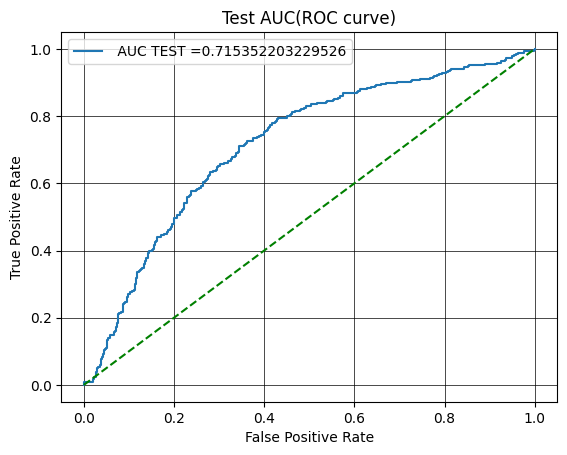

In [38]:
########################################### EMMA ################################################
########################################### EMMA ################################################
########################################### EMMA ################################################

EMMA_results = SVM_results_concat + FCN_results_concat + AUTO_results_concat + GCN_results_concat + EV_GCN_results_concat
EMMA_results_prob = (SVM_results_prob_concat + FCN_results_prob_concat + AUTO_results_prob_concat + GCN_results_prob_concat + EV_GCN_results_prob_concat)/5
EMMA_results[EMMA_results<2.5] = 0
EMMA_results[EMMA_results>=2.5] = 1

test_accuracy = metrics.accuracy_score(test_labels_concat, EMMA_results)
test_fpr, test_tpr, te_thresholds = roc_curve(test_labels_concat, EMMA_results_prob[:,0],pos_label=1)
test_auc = auc(test_fpr, test_tpr)
print('EMMA accuracy is: ', test_accuracy)
print('EMMA AUC is: ', test_auc)


plt.grid()
plt.plot(test_fpr, test_tpr, label=" AUC TEST ="+str(auc(test_fpr, test_tpr)))
plt.plot([0,1],[0,1],'g--')
plt.legend()
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Test AUC(ROC curve)")
plt.grid(color='black', linestyle='-', linewidth=0.5)
plt.show()
